In [1]:
%matplotlib inline

In [2]:
from firedrake import tricontourf

In [3]:
import adolc
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaBasisOptions
from adapt_utils.unsteady.solver import AdaptiveProblem
from adapt_utils.unsteady.swe.tsunami.conversion import lonlat_to_utm

In [5]:
plt.rc('font', **{'size': 16})

In [6]:
kwargs = {
    'level': 1,
    'okada_grid_lon_min': 140,
    'okada_grid_lon_max': 145,
    'okada_grid_lat_min': 35,
    'okada_grid_lat_max': 41,
#     'debug': True,
}
plotting_kwargs = {
    'cmap': 'coolwarm',
    'levels': 50,
}

In [7]:
op = TohokuOkadaBasisOptions(**kwargs)

In [8]:
swp = AdaptiveProblem(op, print_progress=False)
swp.set_initial_condition(annotate_source=False)

In [9]:
kwargs['control_parameters'] = op.control_parameters
mu = 0
sigma = 5
for control in op.active_controls:
    size = np.shape(op.control_parameters[control])
    kwargs['control_parameters'][control] += np.random.normal(loc=mu, scale=sigma, size=size)
op_opt = TohokuOkadaBasisOptions(**kwargs)
N = len(op_opt.indices)

In [10]:
tape_tag = 0
swp = AdaptiveProblem(op_opt, print_progress=False)
swp.set_initial_condition(annotate_source=True, tag=tape_tag)

## Test forward propagation

In [12]:
F = adolc.zos_forward(tape_tag, op_opt.input_vector, keep=0)

In [13]:
F = F.reshape(190, N)
F = np.sum(F, axis=0)
dZ_pert = op_opt.fault.dtopo.dZ.reshape(N)
assert np.allclose(dZ_pert, F)

## Test forward mode differentation

In [14]:
F, dFdm = adolc.fov_forward(tape_tag, op_opt.input_vector, op_opt.seed_matrices)

In [15]:
F = F.reshape(190, N)
F = np.sum(F, axis=0)
assert np.allclose(dZ_pert, F)
dFdm = dFdm.reshape(190, N, 4)
print(dFdm.shape)

(190, 2742, 4)


In [16]:
lonlat_corners = [
    (kwargs['okada_grid_lon_min'], kwargs['okada_grid_lat_min']),
    (kwargs['okada_grid_lon_max'], kwargs['okada_grid_lat_min']),
    (kwargs['okada_grid_lon_min'], kwargs['okada_grid_lat_max']),
]
utm_corners = [lonlat_to_utm(*corner, 54) for corner in lonlat_corners]
xlim = [utm_corners[0][0], utm_corners[1][0]]
ylim = [utm_corners[0][1], utm_corners[2][1]]

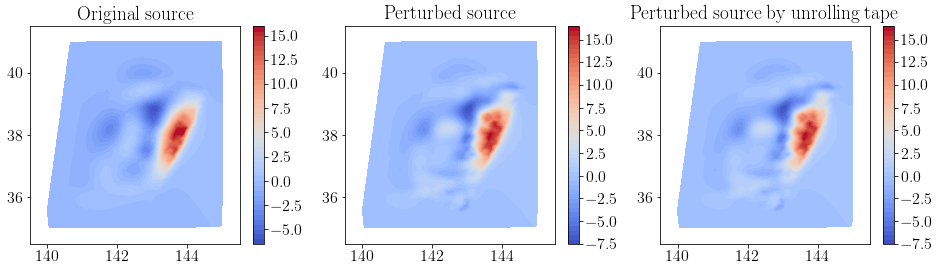

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
dZ = op.fault.dtopo.dZ.reshape(N)
dZ_pert = op_opt.fault.dtopo.dZ.reshape(N)
fig.colorbar(axes[0].tricontourf(X, Y, dZ, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
fig.colorbar(axes[1].tricontourf(X, Y, dZ_pert, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Perturbed source");
fig.colorbar(axes[2].tricontourf(X, Y, F, **plotting_kwargs), ax=axes[2]);
axes[2].set_title("Perturbed source by unrolling tape");
eps = 0.5
for ax in axes:
    ax.set_xlim([lonlat_corners[0][0]-eps, lonlat_corners[1][0]+eps])
    ax.set_ylim([lonlat_corners[0][1]-eps, lonlat_corners[2][1]+eps])